1. Import Models Using River

In [3]:
pip install river

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 60.8 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


2. Use SDV to generate synthetic data off of models

In [5]:
%pip install sdv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 92.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.6/187.6 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.4/84.4 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/

In [13]:
from river.drift import ADWIN
from river.datasets import Bikes
import pandas as pd
from sdv.single_table import GaussianCopulaSynthesizer
from sdv.metadata import SingleTableMetadata

# Step 1: Prepare Original Dataset
bikes = Bikes()
data_list = [x for x, y in bikes.take(100)]  # Collect 100 original samples
df_original = pd.DataFrame(data_list)

# Step 2: Train an SDV Model and Generate Synthetic Data
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_original)

synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(df_original)
df_synthetic = synthesizer.sample(100)  # Generate 100 synthetic samples

# Step 3: Select a Column for Drift Detection
feature_name = "clouds"  # Choose a numerical feature for drift detection

# Step 4: Initialize Drift Detector
drift_detector = ADWIN()

# Step 5: Track Drift and Store Detected Points
drift_points = []  # To store the indices where drift is detected

# Step 6: Feed Synthetic Data into Drift Detector (Comparing Only to Synthetic Past)
for i, value in enumerate(df_synthetic[feature_name]):
    drift_detector.update(value)
    if drift_detector.drift_detected:
        print(f"🚨 Drift detected at synthetic sample {i+1}, value: {value}")


/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


3. Use River to determine concept drift in the synthetic data

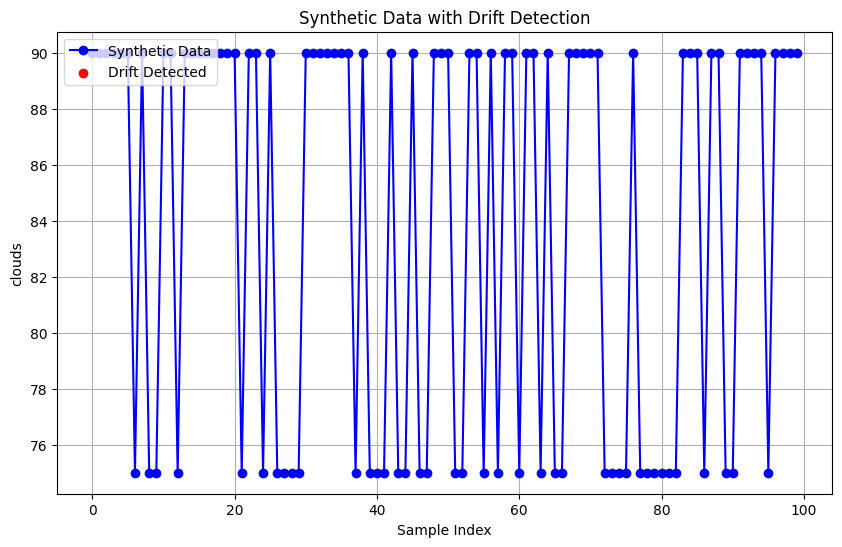

In [14]:
import matplotlib.pyplot as plt


# Step 7: Visualize Synthetic Data and Drift Points
plt.figure(figsize=(10, 6))
plt.plot(df_synthetic[feature_name], label='Synthetic Data', color='blue', marker='o')
plt.scatter(drift_points, df_synthetic[feature_name].iloc[drift_points], color='red', label='Drift Detected', zorder=5)

plt.title("Synthetic Data with Drift Detection")
plt.xlabel("Sample Index")
plt.ylabel(feature_name)
plt.legend(loc="upper left")
plt.grid(True)
plt.show()
